In [58]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

In [59]:
# go to parent directory
os.chdir("..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "CIFAR-10"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

In [60]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASS_NAMES)

In [61]:
from sklearn.preprocessing import LabelEncoder

def give_class_name(y:np.ndarray) -> np.ndarray:
    enc = LabelEncoder().fit(CLASS_NAMES)
    y_labeled = enc.inverse_transform(y)
    
    return y_labeled

### Load CIFAR-10 data

In [62]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Image scaling to 0-1
# train_images = train_images / 255.0
# test_images = test_images / 255.0

if train_labels.ndim == 2:
    train_labels = train_labels.flatten()
    test_labels = test_labels.flatten()


total_data = f"Total Data on RAM -{(train_images.size + test_images.size) / 1024**2 : .2f} MB"
total_data

'Total Data on RAM - 175.78 MB'

### Displaying the first image in the training set

In [63]:
# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"(incorrect, {labels[i]})"
        plt.title(title)
        plt.axis("off")
    plt.show()
    

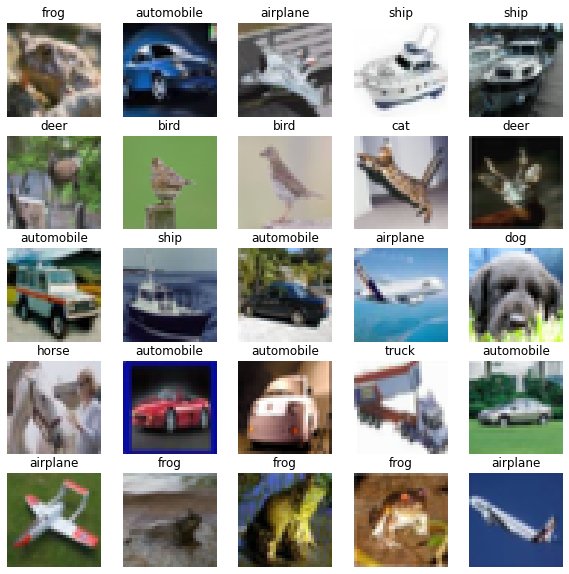

In [64]:
# display 25 random images from the training set
rnd_pts = np.random.randint(0, train_images.shape[0], 25)
images = train_images[rnd_pts, :, :]
labels = train_labels[rnd_pts]

display_image_grid(images, give_class_name(labels))

### Preprocessing the data

In [65]:
# One hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

## MODELS

In [66]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, Input, Add, Activation, BatchNormalization, AveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score


In [67]:
MODELS_PATH = ROOT_DIR / "models"
INPUT_SHAPE = train_images.shape[1:]
models_performance = {}
TRAIN_MODELS = False

In [68]:
def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)


# ploting the model training history
def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


def confusion_matrix_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cm = confusion_matrix(y_test, y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu")
    cm_plot.set_title('Confusion Matrix')
    cm_plot.set_xlabel('Predicted Label')
    cm_plot.set_ylabel('True Label')
    if labels:
        cm_plot.set_xticklabels(labels)
        cm_plot.set_yticklabels(labels)
        
    plt.show()
    
def classification_report_plot(y_test, y_pred, figsize=(12, 10), labels=None):
    plt.figure(figsize=figsize)
    cr = classification_report(y_test, y_pred, output_dict=True)
    if labels:
        cr = classification_report(y_test, y_pred, output_dict=True, target_names=labels)
    cr_heatmap = sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt='.2f')
    cr_heatmap.set_title('Classification Report')
    cr_heatmap.set_xlabel('Metrics')
    cr_heatmap.set_ylabel('Classes')
        
    plt.show()
    
def get_model_performance(y_true, y_pred):
    accuracy = accuracy_score(test_labels, test_labels_pred)
    f1_scr = f1_score(test_labels, test_labels_pred, average='weighted')
    precision_scr = precision_score(test_labels, test_labels_pred, average='weighted')
    recall_scr = recall_score(test_labels, test_labels_pred, average='weighted')
    
    performance = {
        "Accuracy": accuracy,
        "F1 Score": f1_scr,
        "Precision": precision_scr,
        "Recall": recall_scr
    }
    
    return performance

### Simple Sequential Model

#### init

In [69]:
from tensorflow.keras.models import Sequential

model_name = "simple_sequential"

def simple_sequential_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=input_shape))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [70]:
model = simple_sequential_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_34 (Bat  (None, 16, 16, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 8, 8, 64)        

#### Train

In [71]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 6))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/{model_name}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check]

In [72]:
train_model = os.path.exists(f"{MODELS_PATH}/{model_name}.h5") and TRAIN_MODELS

if train_model:
    history = model.fit(train_images, y_train, 
                        epochs=30, batch_size=64,
                        validation_split=0.2, callbacks=callbacks)

In [73]:
if train_model:
    plot_model_performance(history)

In [74]:
if train_model:
    model.evaluate(test_images, y_test)

#### Testing and Evaluating

In [75]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/{model_name}.h5')

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)

2022-06-15 07:29:37.767234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


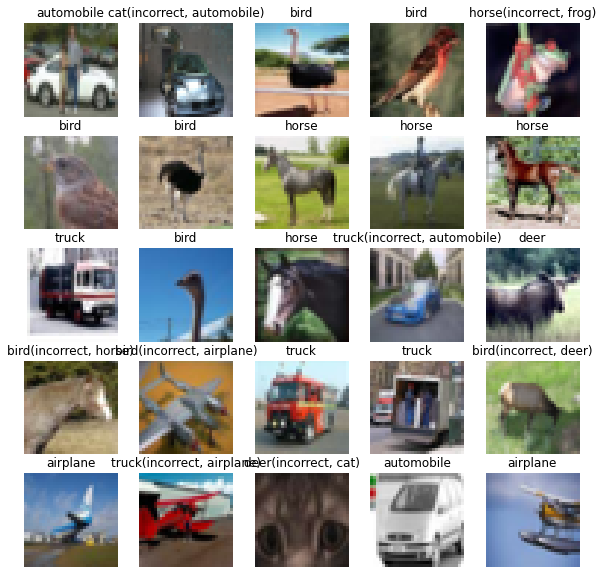

In [76]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


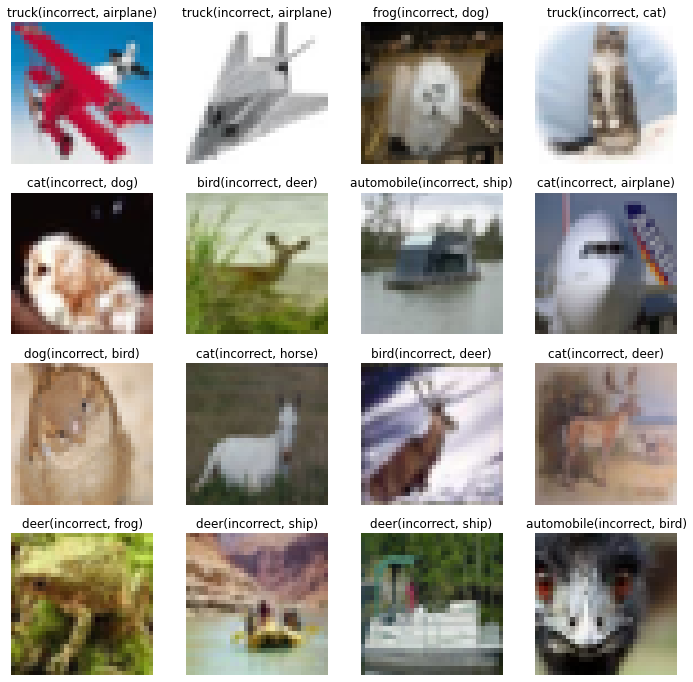

In [77]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

Score: 0.7111


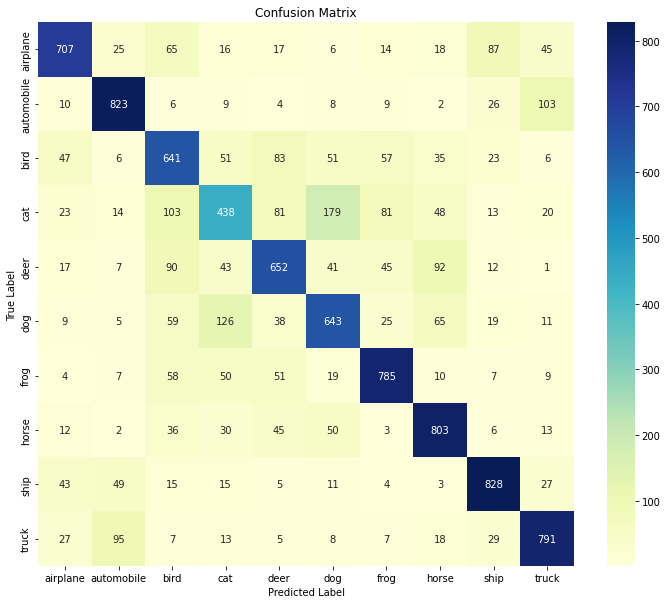

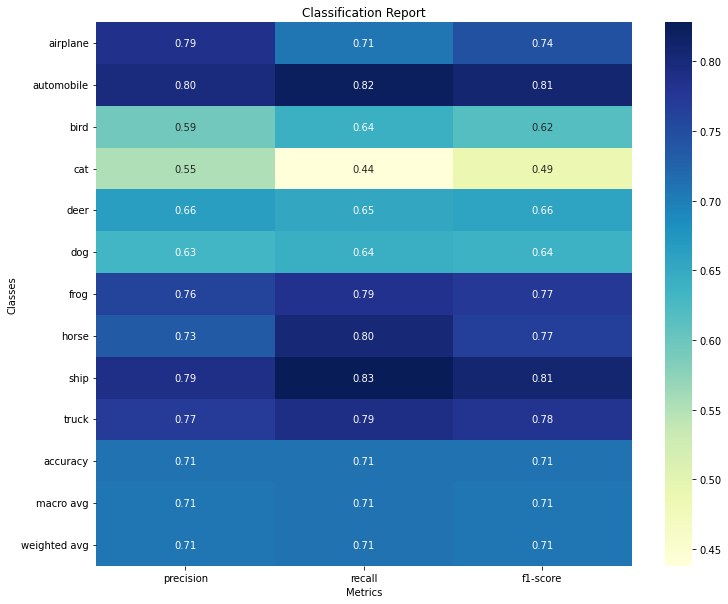

In [78]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)

print("Score:", performance["Accuracy"])
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)

models_performance[model_name] = performance

#### 71% is not good enough accuracy, Will apply more models untill we get good results

### Deeper Sequential Model

#### init

In [79]:
from tensorflow.keras.models import Sequential

model_name = "deeper_sequential"

def deeper_sequential_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Rescaling(1./255, input_shape=input_shape))
    
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [80]:
model = deeper_sequential_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 8, 128)       

#### Train

In [81]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 6))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/{model_name}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check]

In [82]:
train_model = os.path.exists(f"{MODELS_PATH}/{model_name}.h5") and TRAIN_MODELS

if train_model:
    history = model.fit(train_images, y_train, 
                    epochs=30, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)

In [83]:
if train_model:
    plot_model_performance(history)

In [84]:
if train_model:
    model.evaluate(test_images, y_test)

#### Testing and Evaluating

In [85]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/{model_name}.h5')

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)

2022-06-15 07:29:42.447543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


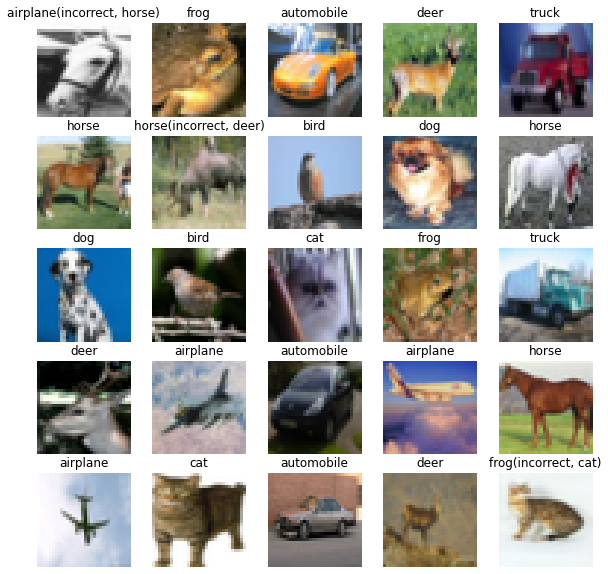

In [86]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


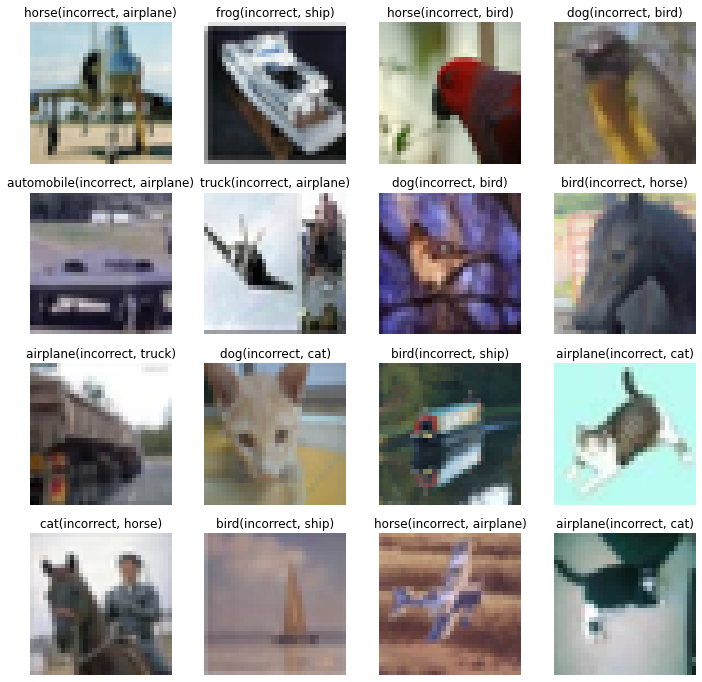

In [87]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

Score: 0.7632


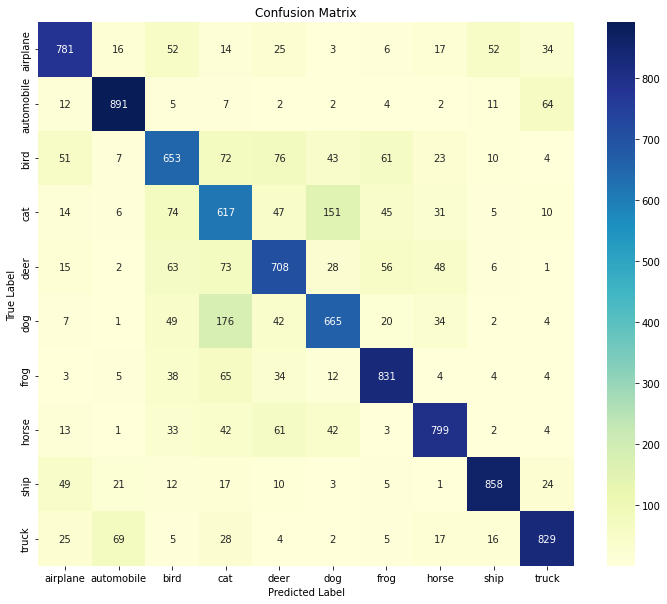

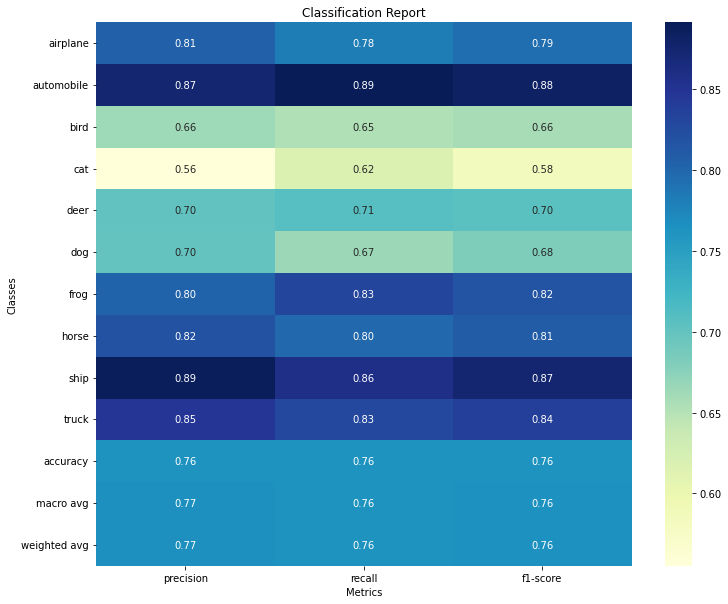

In [88]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)

print("Score:", performance["Accuracy"])
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)

models_performance[model_name] = performance

#### 76% is not good enough accuracy, Will apply more models untill we get good results

### VGG-Like Model

#### init

In [89]:
from tensorflow.keras.models import Model

model_name = "complex_sequential"   # complex_sequential - Inspired by VGG16's blocks

# def block(input_tensor, filters, kernel_size, strides=(1, 1), activation='relu', padding='same'):
#     x = Conv2D(filters, kernel_size, strides=strides, padding=padding, activation=activation)(input_tensor)
#     x = BatchNormalization()(x)
#     return x

def block(input_tensor, filters: int, convolutional_layers: int, kernel_size: int = 3, activation='relu', padding='same', poll_size: int = 2):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(input_tensor)
    for _ in range(convolutional_layers - 1):
        x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
        
    x = MaxPooling2D(pool_size=poll_size)(x)
    x = BatchNormalization()(x)
    
    return x
    

def complex_sequential_model(input_shape, num_classes):
    input_scale = 1./255

    inputs = Input(shape=input_shape)
    x = Rescaling(input_scale)(inputs)
    
    x = block(x, 64, 2, activation='relu', padding='same')      # block 1(2) - 28x28x3 -> 14x14x64
    x = block(x, 128, 2, activation='relu', padding='same')     # block 2(2) - 14x14x64 -> 7x7x128
    x = block(x, 256, 2, activation='relu', padding='same')     # block 3(2) - 7x7x128 -> 4x4x256
    
    x = Flatten()(x)                                            # flatten - 4x4x256 -> 4096
    
    x = Dense(256, activation='relu')(x)                        # dense(1) - 4096 -> 512
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(128, activation='relu')(x)                        # dense(1) - 512 -> 128
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    x = Dense(32, activation='relu')(x)                        # dense(1) - 128 -> 32
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)       # dense(1) - 32 -> 10
    
    model = Model(inputs, outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [90]:
model = complex_sequential_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_39 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                          

#### Train

In [91]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=5, mode='max')
# learning rate scheduler
lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 8))
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/{model_name}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks = [es, mdl_check, lrd]

In [92]:
train_model = os.path.exists(f"{MODELS_PATH}/{model_name}.h5") and TRAIN_MODELS

if train_model:
    history = model.fit(train_images, y_train, 
                    epochs=40, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)

In [93]:
if train_model:
    plot_model_performance(history)

In [94]:
train_model = os.path.exists(f"{MODELS_PATH}/{model_name}.h5") and TRAIN_MODELS

if train_model:
    model.evaluate(test_images, y_test)

#### Testing and Evaluating

In [95]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/{model_name}.h5')

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)

2022-06-15 07:29:48.089375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


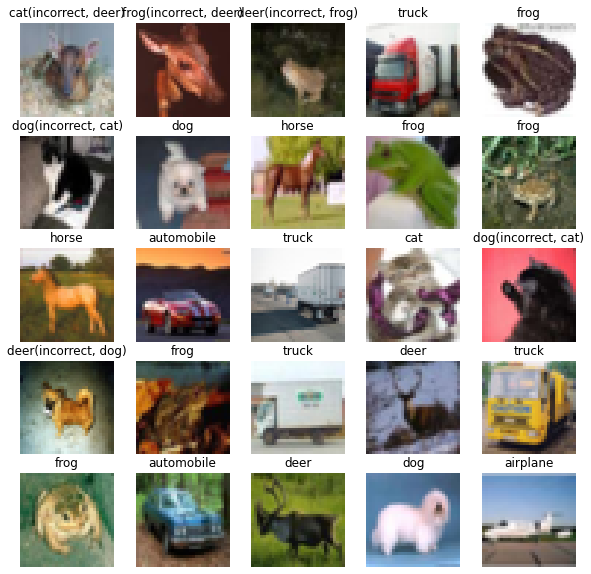

In [96]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


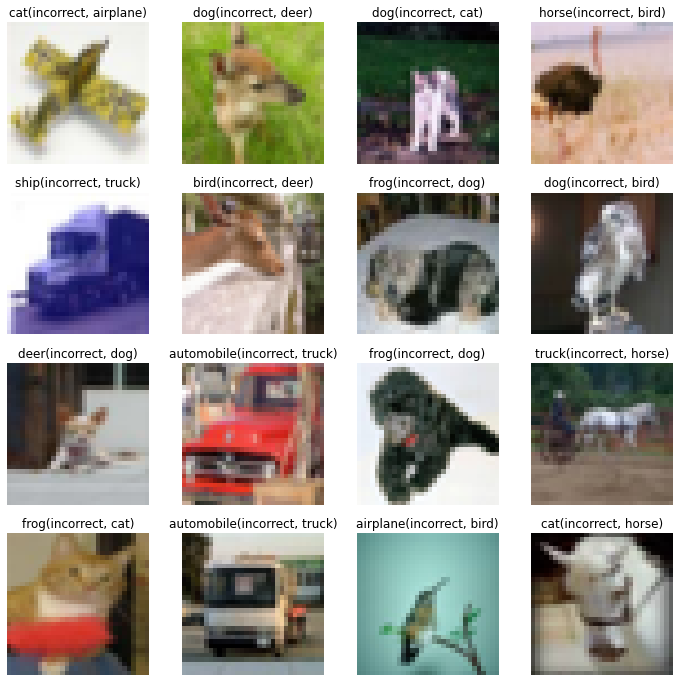

In [97]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

Score: 0.7557


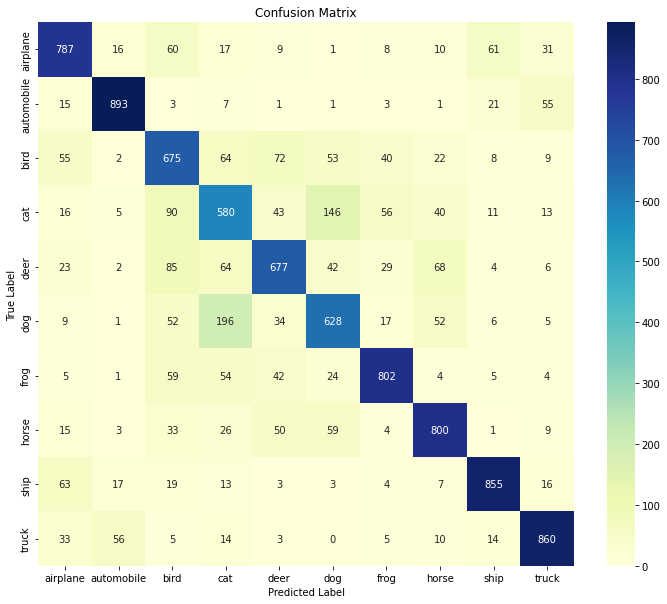

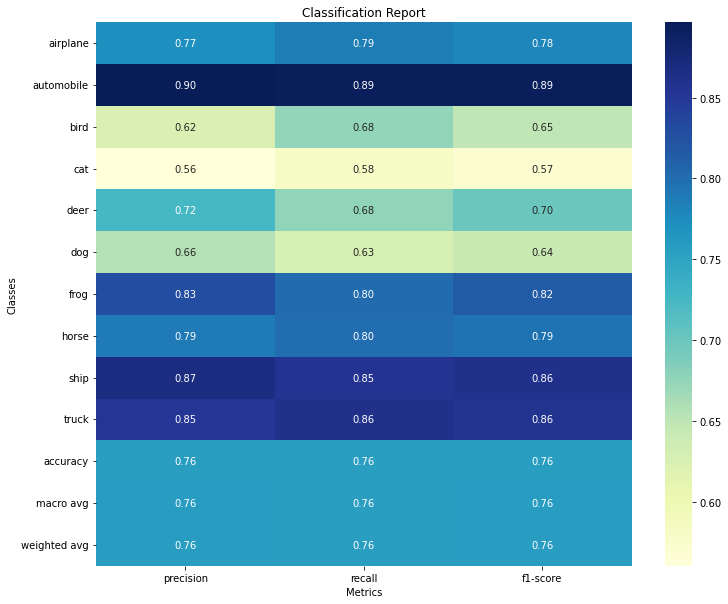

In [98]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)

print("Score:", performance["Accuracy"])
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)

models_performance[model_name] = performance

#### 76% is not good enough accuracy, Will apply more models untill we get good results

### Resnet-Like Model

#### init

In [99]:
from tensorflow.keras.models import Model
from typing import Union

list_or_int = Union[int, list]

model_name = "Residual_blocks_model"   # complex_sequential - Inspired by Resnet Model

def get_filters(filters: list_or_int) -> tuple[int, int, int]:
    if type(filters) == list:
        if len(filters) != 3:
            raise ValueError("filters must be a list of 3 integers")
        return filters
    else:
        return filters, filters, filters

def identity_block(input_tensor, filters: int, kernel_size: int = 3, activation='relu'):
    """
    Arguments:
    input_tensor -- input tensor of shape (batch_size, n_rows, n_cols, n_channels)
    filters: int -- number of filters in the convolution layer

    kernel_size: int(3) -- size of the kernel
    activation: str('relu') -- activation function
    poll_size: int(2) -- size of the pooling layer
    """

    F1, F2, F3 = get_filters(filters)

    # 1st component
    x = Conv2D(F1, (1,1), padding="valid")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # 2nd component
    x = Conv2D(F2, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # 3rd component
    x = Conv2D(F3, (1,1), padding="valid")(x)
    x = BatchNormalization()(x)

    # final component
    x = Add()([x, input_tensor])
    x = Activation(activation)(x)

    return x


def convolutional_block(input_tensor, filters: int, kernel_size: int = 3, activation='relu', stride: int=2):
    """
    Arguments:
    input_tensor -- input tensor of shape (batch_size, n_rows, n_cols, n_channels)
    filters: int -- number of filters in the convolution layer

    kernel_size: int(3) -- size of the kernel
    activation: str('relu') -- activation function
    poll_size: int(2) -- size of the pooling layer
    """

    F1, F2, F3 = get_filters(filters)

    # 1st component
    x = Conv2D(F1, (1, 1), strides=stride, padding="valid")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # 2nd component
    x = Conv2D(F2, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # 3rd component
    x = Conv2D(F3, (1, 1), padding="valid")(x)
    x = BatchNormalization()(x)
    
    # input_tensor component
    x_ = Conv2D(F3, (1, 1), strides=stride, padding="valid")(input_tensor)
    x_ = BatchNormalization()(x_)
    
    # final component (joining the input_tensor_component and 3rd_component)
    x = Add()([x, x_])
    x = Activation(activation)(x)
    
    return x


def residual_blocks_model(input_shape, num_classes):
    input_scale = 1./255

    inputs = Input(shape=input_shape)
    x = Rescaling(input_scale)(inputs)
    # Convolutional layers
    # Block 1
    x = Conv2D(64, (3, 3), strides=(1, 1), padding="same")(x)           # n x n x 3 -> n x n x 64
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)                               # n x n x 64 -> (n/2) x (n/2) x 64
    # Block 2
    x = convolutional_block(x, [64, 64, 256], kernel_size=3)            # (n/2) x (n/2) x 64 -> (n/4) x (n/4) x 256
    x = identity_block(x, [64, 64, 256], kernel_size=3)                 # (n/4) x (n/4) x 256 -> (n/4) x (n/4) x 256
    x = identity_block(x, [64, 64, 256], kernel_size=3)                 # (n/4) x (n/4) x 256 -> (n/4) x (n/4) x 256
    # Block 3
    x = convolutional_block(x, [128, 128, 512], kernel_size=3, stride=2) # (n/4) x (n/4) x 256 -> (n/8) x (n/8) x 512
    x = identity_block(x, [128, 128, 512], kernel_size=3)               # (n/8) x (n/8) x 512 -> (n/8) x (n/8) x 512
    x = identity_block(x, [128, 128, 512], kernel_size=3)               # (n/8) x (n/8) x 512 -> (n/8) x (n/8) x 512
    # Final Block
    x = MaxPooling2D()(x)                                              # (n/8) x (n/8) x 512 -> (n/16) x (n/16) x 512
    # Final block
    x = MaxPooling2D()(x)                                               # (n/4) x (n/4) x 256 -> (n/8) x (n/8) x 256
    x = Flatten()(x)
    
    # Fully connected layers
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    #output layer
    output_layer = Dense(num_classes, activation='softmax')(x)
    # create model
    model = Model(inputs=inputs, outputs=output_layer, name=model_name)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [100]:
model = residual_blocks_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

Model: "Residual_blocks_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_7 (Rescaling)        (None, 32, 32, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 32, 32, 64)   1792        ['rescaling_7[0][0]']            
                                                                                                  
 batch_normalization_45 (BatchN  (None, 32, 32, 64)  256         ['conv2d_43[0][0]']              
 ormalization)                                                                

#### Train

In [101]:
# callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint

# Early stopping
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=6, mode='max')
# model checkpoint
mdl_check = ModelCheckpoint(filepath=f'{MODELS_PATH}/{model_name}.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# learning rate scheduler
def get_lr(epoch):
    lr_ = 1e-3
    k = 0.15
    lr = lr_ * np.exp(-k * epoch)
    return lr

lrd = LearningRateScheduler(lambda epoch: 1 / 10**(3 + epoch // 8))

callbacks = [es, mdl_check]
callbacks.append(lrd)

In [102]:
train_model = os.path.exists(f"{MODELS_PATH}/{model_name}.h5") and TRAIN_MODELS

if train_model:
    history = model.fit(train_images, y_train, 
                    epochs=40, batch_size=64,
                    validation_split=0.2, callbacks=callbacks)

In [103]:
if train_model:
    plot_model_performance(history)

In [104]:
if train_model:
    model.evaluate(test_images, y_test)

#### Testing and Evaluating

In [105]:
from tensorflow.keras.models import load_model
model = load_model(f'{MODELS_PATH}/{model_name}.h5')

x, y = test_images, test_labels
test_labels_pred = predict_label(x, model)

2022-06-15 07:29:56.273096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


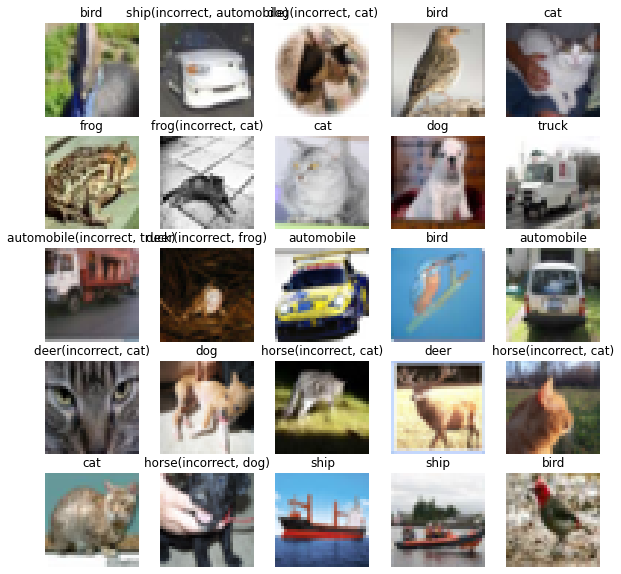

In [106]:
rnd_pts = np.random.randint(0, test_images.shape[0], 25)
images = test_images[rnd_pts, :, :]
labels = test_labels[rnd_pts]
labels_pred  = test_labels_pred[rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred))


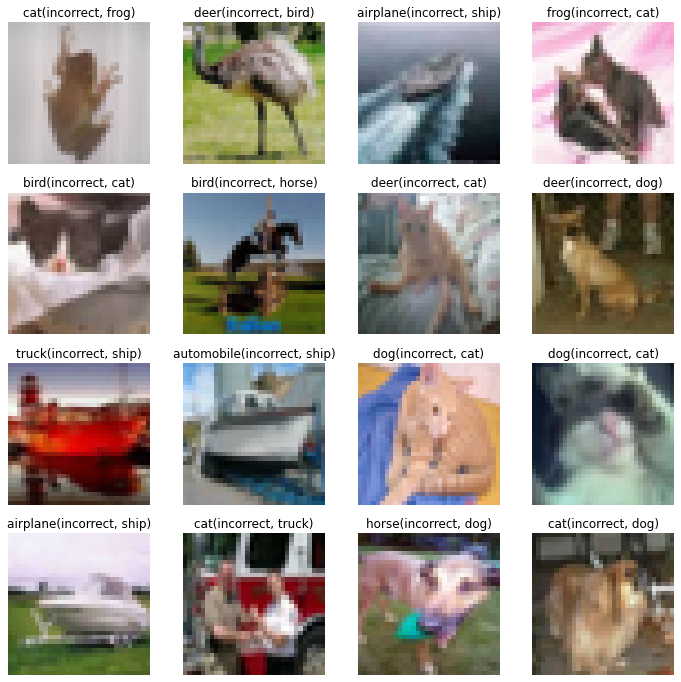

In [107]:
# Plotting only the incorrect images

labels_pred = predict_label(test_images, model)
incorrect_pred = test_labels != labels_pred

rnd_pts = np.random.randint(0, incorrect_pred.sum(), 16)

images = test_images[incorrect_pred, :, :][rnd_pts, :, :]
labels = test_labels[incorrect_pred][rnd_pts]
labels_pred = labels_pred[incorrect_pred][rnd_pts]

display_image_grid(images, give_class_name(labels), give_class_name(labels_pred), shape=(4, 4), figsize=(12, 12))

Score: 0.75


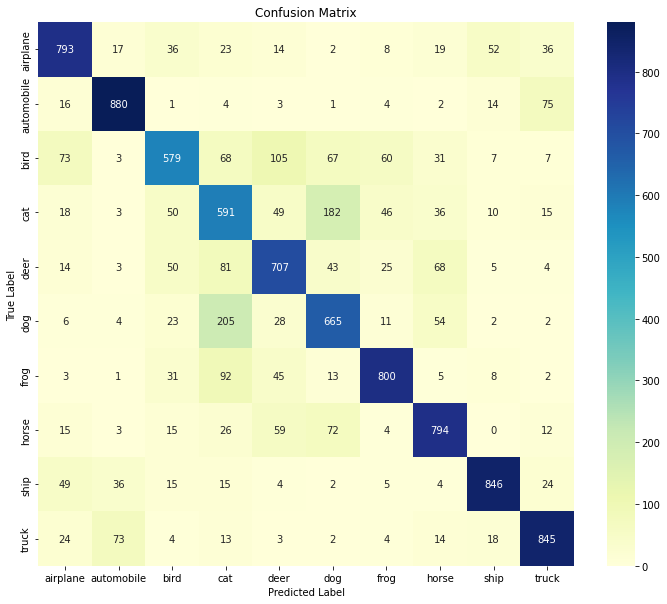

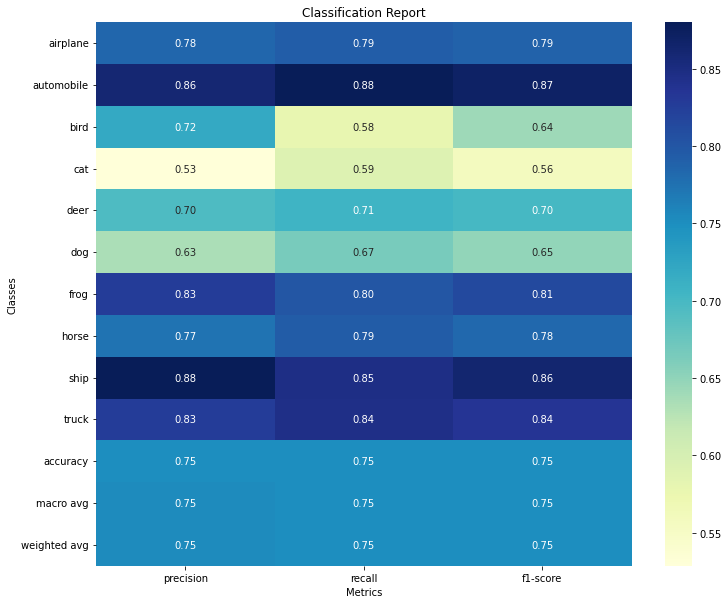

In [108]:
#  confusion matrix and classification report

performance = get_model_performance(test_labels, test_labels_pred)

print("Score:", performance["Accuracy"])
confusion_matrix_plot(y, test_labels_pred, labels=CLASS_NAMES)
classification_report_plot(y, test_labels_pred, labels=CLASS_NAMES)

models_performance[model_name] = performance

#### 76% is not good enough accuracy, Will apply more models untill we get good results

## Results

In [125]:
models_performance_df = pd.DataFrame(models_performance).T

models_performance_df.sort_values(by="F1 Score", ascending=False)

,Accuracy,F1 Score,Precision,Recall
deeper_sequential,0.7632,0.764093,0.765608,0.7632
complex_sequential,0.7557,0.756135,0.757105,0.7557
Residual_blocks_model,0.7500,0.750381,0.752913,0.7500
simple_sequential,0.7111,0.708486,0.708355,0.7111


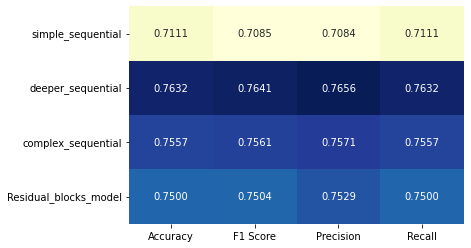

In [131]:
# plot on heatmap
sns.heatmap(models_performance_df, annot=True, cmap="YlGnBu", cbar=False, fmt=".4f")
plt.show()